In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [12]:
class MLP(nn.Module):
    """
    sizes: list of layer sizes, e.g. [in, h1, h2, ..., out]
    activation: activation for hidden layers (callable)
    out_activation: activation for the final layer (callable or None)
    dropout: float in [0,1) (applied to hidden layers)
    batchnorm: bool (BatchNorm1d on hidden layers)
    """
    def __init__(self, sizes, activation=nn.ReLU(), out_activation=None,
                 dropout=0.0, batchnorm=False):
        super().__init__()
        assert len(sizes) >= 2, "sizes must include [in_features, out_features]"

        layers = []
        for i in range(len(sizes)-1):
            in_f, out_f = sizes[i], sizes[i+1]
            layers.append(nn.Linear(in_f, out_f))

        self.layers = nn.ModuleList(layers)
        self.activation = activation
        self.out_activation = out_activation
        self.dropout = nn.Dropout(dropout) if dropout and dropout > 0 else None
        self.bn = nn.ModuleList(
            [nn.BatchNorm1d(sizes[i+1]) for i in range(len(sizes)-2)]
        ) if batchnorm else None

        # Kaiming init for hidden layers (good for ReLU-like activations)
        for lin in self.layers[:-1]:
            nn.init.kaiming_normal_(lin.weight, nonlinearity='relu')
            nn.init.zeros_(lin.bias)

    def forward(self, x):
        # hidden layers
        for i, lin in enumerate(self.layers[:-1]):
            x = lin(x)
            if self.bn: x = self.bn[i](x)
            x = self.activation(x)
            if self.dropout: x = self.dropout(x)
        # output layer
        x = self.layers[-1](x)
        if self.out_activation is not None:
            x = self.out_activation(x)
        return x


## **Instantiate the model**

In [13]:
model = MLP(sizes=[2, 32, 16, 1], activation=nn.ReLU(), out_activation=None,
            dropout=0.1, batchnorm=True)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)


## **Training Loop**

In [14]:
def train(model, X, y, criterion, optimizer, epochs=1000, batch_size=128):
    N = X.size(0)
    losses = []
    model.train()
    for epoch in range(epochs):
        # mini-batch sampling (without replacement each epoch)
        idx = torch.randperm(N)
        for start in range(0, N, batch_size):
            batch_idx = idx[start:start+batch_size]
            xb, yb = X[batch_idx], y[batch_idx]

            logits = model(xb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
    return losses

losses = train(model, X, y, criterion, optimizer, epochs=600, batch_size=128)


## **Generate Data**

In [15]:
nPerClust = 200
blur = 1.0

A = [1, 3]
B = [1, -2]

a = np.column_stack([A[0] + np.random.randn(nPerClust) * blur,
                     A[1] + np.random.randn(nPerClust) * blur])
b = np.column_stack([B[0] + np.random.randn(nPerClust) * blur,
                     B[1] + np.random.randn(nPerClust) * blur])

data_np = np.vstack([a, b]).astype(np.float32)
labels_np = np.vstack([np.zeros((nPerClust, 1), dtype=np.float32),
                       np.ones((nPerClust, 1), dtype=np.float32)])

X = torch.tensor(data_np)           # shape (N, 2)
y = torch.tensor(labels_np)         # shape (N, 1)


## **Evaluate the model accuracy**

In [16]:
model.eval()
with torch.no_grad():
    logits = model(X)
    preds = (logits > 0).float()  # threshold at 0 for logits
    acc = (preds.eq(y).float().mean().item()) * 100.0

print(f"Training accuracy: {acc:.2f}%")


Training accuracy: 99.25%


## **Visualize the loss curve**

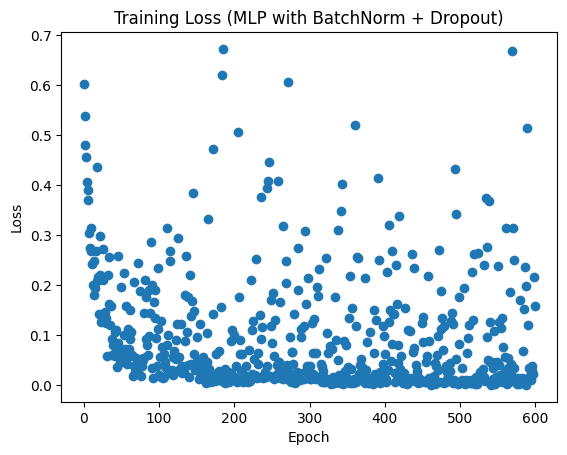

In [19]:
plt.figure()
plt.plot(losses,'o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (MLP with BatchNorm + Dropout)")
plt.show()